# Proyecto: Análisis de sentimiento en reseñas de peliculas

## Los Michingenieros

- Mateo Chaparro 201730891
- Daniel Beltran 201812807

# Instalación de librerias y dependencias importantes para el proyecto

In [1]:
#Modelo de word-embeddings de spacy
!python -m spacy download es_core_news_lg

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-04-01 04:07:14.442161: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 04:07:17.131661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-01 04:07:20.828298: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 1.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the packag

In [2]:
#Detectar idioma
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993243 sha256=b9763795d9675d76f673ea19ad72c30d07b4a9ff980508a413a8794c6e1d4023
  Stored in directory: /root/.cache/pip/wheels/d1/c1/d9/7e068de779d863bc8f8fc9467d85e25cfe47fa5051fff1a1bb
Successfully built langdetect


In [38]:
#Librerias básicas
import numpy as np
import random

#pandas
import pandas as pd

#Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
import joblib

#Preprocesamiento
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler

#Procesamiento del lenguaje
import nltk
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
#Se intento hacer reducción de dimensionalidad con TruncatedSVD pero los resultados sin usarlo fueron considerablemente mejores por lo que finalmente no se usó pero se deja como evidencia de que se analizó
from sklearn.decomposition import TruncatedSVD
from langdetect import detect, DetectorFactory
import spacy


#Modelos a probar
from sklearn.ensemble import RandomForestClassifier
#from sklearn.naive_bayes import GaussianNB
#Segun lo investigado MultinomialNB suele dar mejores resultados que otros clasisficadores 'naive_bayes' en procesamiento de lenguaje natural
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

#Selección de modelos
from sklearn.model_selection import GridSearchCV, train_test_split
#Metricas
from sklearn.metrics import make_scorer, confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay, average_precision_score

## Descargando ntlk y probando que quedó funcionando
Descargar todo:

- d
- all 
- q     

In [4]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package bcp47 to /root/nltk_data...
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package bllip_wsj_no_aux to /root/nltk_data...
       |   Unzipping models/bllip_wsj_no_aux.zip.
       | Downloading package book_grammars to /root/nltk_data...
       |   Un


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [ ]:
len(stopwords.words('spanish'))

313

## Revisando que la libreria langdetect funcione correctamente

In [ ]:
text='Hola mundo te quiero mucho'
DetectorFactory.seed = 0
detect(text)

'es'

# Cargue de datos y análisis de la calidad de los mismos

In [ ]:
enco='UTF-8'
data = pd.read_csv("/content/MovieReviews.csv", encoding = enco,sep=',', header=0, index_col=0) 
df = data.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_es    5000 non-null   object
 1   sentimiento  5000 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


In [ ]:
df.head()

review_es sentimiento
0  Si está buscando una película de guerra típica...    positivo
1  Supongo que algunos directores de películas de...    positivo
2  Es difícil contarle más sobre esta película si...    positivo
3  La película comienza muy lentamente, con el es...    positivo
4  Esta película es verdadera acción en su máxima...    positivo

In [ ]:
df.describe()

review_es sentimiento
count                                                5000        5000
unique                                               4998           2
top     Después de ver a Meredith en "Más allá de la p...    positivo
freq                                                    2        2500

In [ ]:
df.groupby('sentimiento').describe()

review_es         \
                count unique   
sentimiento                    
negativo         2500   2499   
positivo         2500   2499   

                                                                     
                                                           top freq  
sentimiento                                                          
negativo     Linda Lovelace fue víctima de una mujer sádica...    2  
positivo     Después de ver a Meredith en "Más allá de la p...    2

## Ingenieria de atributos

In [ ]:
df['length'] = df['review_es'].apply(len)

In [ ]:
df['length'].describe()

count     5000.000000
mean      1385.930000
std       1032.897373
min         60.000000
25%        750.000000
50%       1030.500000
75%       1699.250000
max      12375.000000
Name: length, dtype: float64

In [ ]:
positiv = df[df['sentimiento']=='positivo']
negativ = df[df['sentimiento']=='negativo']

In [ ]:
positiv['length'].describe()

count     2500.000000
mean      1413.876800
std       1086.286294
min        111.000000
25%        743.000000
50%       1032.500000
75%       1741.000000
max      12375.000000
Name: length, dtype: float64

In [ ]:
negativ['length'].describe()

count    2500.00000
mean     1357.98320
std       976.01245
min        60.00000
25%       755.75000
50%      1029.00000
75%      1644.75000
max      6261.00000
Name: length, dtype: float64

array([<Axes: title={'center': 'negativo'}>,
       <Axes: title={'center': 'positivo'}>], dtype=object)

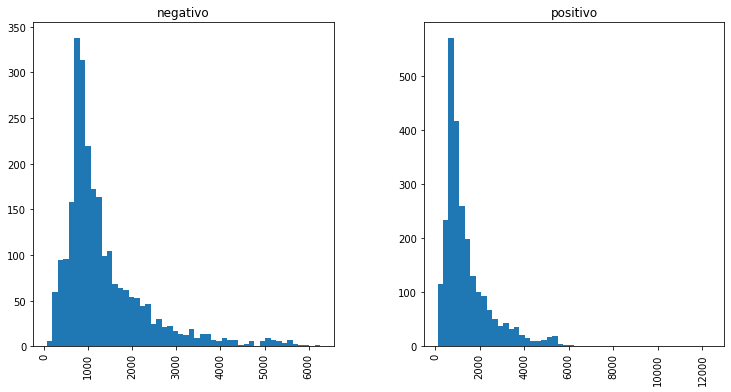

In [ ]:
df.hist(column='length',by='sentimiento',bins=50,figsize=(12,6))

Se evidencia que la varianza entre las clases para el atributo de longitud tiene distribución muy similar y que por tanto no es relevante en el entrenamiento del modelo.

# Preprocesamiento

## Pruebas y análisis de que procesos se le deben aplicar a los datos

In [ ]:
df = data.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_es    5000 non-null   object
 1   sentimiento  5000 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


In [ ]:
df.describe()

review_es sentimiento
count                                                5000        5000
unique                                               4998           2
top     Después de ver a Meredith en "Más allá de la p...    positivo
freq                                                    2        2500

In [ ]:
df=df.drop_duplicates(subset='review_es')

In [ ]:
df.groupby('sentimiento').describe()

review_es         \
                count unique   
sentimiento                    
negativo         2499   2499   
positivo         2499   2499   

                                                                     
                                                           top freq  
sentimiento                                                          
negativo     Woody Allen (que tengo que confesar desde el p...    1  
positivo     Si está buscando una película de guerra típica...    1

In [ ]:
df['review_es']=df['review_es'].astype(str)
df['idioma'] = df['review_es'].apply(detect)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_es    4998 non-null   object
 1   sentimiento  4998 non-null   object
 2   idioma       4998 non-null   object
dtypes: object(3)
memory usage: 156.2+ KB


In [ ]:
df.groupby('idioma').describe()

review_es                                                            \
           count unique                                                top   
idioma                                                                       
en           196    196  Even a decade after "Frontline" aired on the A...   
es          4801   4801  Si está buscando una película de guerra típica...   
id             1      1  ..... Whoops: parece que le va a costar una fr...   

            sentimiento                         
       freq       count unique       top  freq  
idioma                                          
en        1         196      2  positivo   102  
es        1        4801      2  negativo  2405  
id        1           1      1  positivo     1

In [ ]:
df[df['idioma']=='id']

review_es sentimiento idioma
785  ..... Whoops: parece que le va a costar una fr...    positivo     id

In [ ]:
df.head()

review_es sentimiento idioma
0  Si está buscando una película de guerra típica...    positivo     es
1  Supongo que algunos directores de películas de...    positivo     es
2  Es difícil contarle más sobre esta película si...    positivo     es
3  La película comienza muy lentamente, con el es...    positivo     es
4  Esta película es verdadera acción en su máxima...    positivo     es

In [ ]:
df = df[(df.idioma == 'es')]
df = df.drop(['idioma'], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4801 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_es    4801 non-null   object
 1   sentimiento  4801 non-null   object
dtypes: object(2)
memory usage: 112.5+ KB


In [ ]:
df.head()

review_es sentimiento
0  Si está buscando una película de guerra típica...    positivo
1  Supongo que algunos directores de películas de...    positivo
2  Es difícil contarle más sobre esta película si...    positivo
3  La película comienza muy lentamente, con el es...    positivo
4  Esta película es verdadera acción en su máxima...    positivo

In [ ]:
df.groupby('sentimiento').describe()

review_es         \
                count unique   
sentimiento                    
negativo         2405   2405   
positivo         2396   2396   

                                                                     
                                                           top freq  
sentimiento                                                          
negativo     Woody Allen (que tengo que confesar desde el p...    1  
positivo     Si está buscando una película de guerra típica...    1

## Definición de las funciones de procesamiento basadas en lo encontrado en los pasos anteriores

In [5]:
def pre_pre_processing(df):
  DetectorFactory.seed = 0
  df=df.drop_duplicates(subset='review_es')
  df['review_es']=df['review_es'].astype(str)
  df['idioma'] = df['review_es'].apply(detect)
  df = df[(df.idioma == 'es')]
  df = df.drop(['idioma'], axis=1)
  df.sentimiento=df.sentimiento.map({
      'positivo':1,
      'negativo':0
  })
  return df

In [6]:
def text_pre_processing(text):
  #Palabras de parada
  stopw = stopwords.words('spanish')
  #Quitar puntuación
  no_punct = ''.join([c for c in text if c not in string.punctuation])
  #Quitar palabras de parada y poner todo en minuscula
  no_stop = ' '.join([w.lower() for w in no_punct.split() if w.lower() not in stopw])
  return no_stop


In [7]:
def pre_process_df(df):
  column_names=['review_es']
  df['review_es']=df['review_es'].apply(text_pre_processing)
  df = df[df.columns.intersection(column_names)]
  #TfidfVectorizer().fit_transform(df['review_es'])
  return df.review_es

## Exportando los datos pre-pre-procesados

In [45]:
df = data.copy()
df = pre_pre_processing(df)

In [50]:
df.to_csv('/content/datos_procesados.csv',index=False)

# Preparación previa al gridseach

In [ ]:
df = data.copy()
df = pre_pre_processing(df)

<ipython-input-32-6bb1279a195f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_es']=df['review_es'].astype(str)
<ipython-input-32-6bb1279a195f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['idioma'] = df['review_es'].apply(detect)


In [ ]:
columns = list(df.columns)
columns.remove('sentimiento')
x_train, x_test, y_train, y_test = train_test_split(
    df[columns],
    df.sentimiento,
    test_size=0.2,
    random_state=777,
    stratify=df.sentimiento
)

### Parametros Random Forest



In [ ]:
max_depths = (10,15,20)
min_samples_splits=(2,3,4)
min_samples_leafs=(1,2,3)
n_estimators = (50, 100, 150)
max_features = ('sqrt','log2')
rfc_params={
    'model': (RandomForestClassifier(),),
    'model__max_depth':max_depths,
    'model__min_samples_split': min_samples_splits,
    'model__min_samples_leaf':min_samples_leafs,
    'model__max_features':max_features,
    'model__n_estimators':n_estimators
}

### Parametros Multinomial Naive Bayes

In [ ]:
alphas=(0,0.25,0.5,0.75,1.0)
force_alphas=(True,False)
class_priors=(None,[0.5,0.5])
fit_priors=(True,False)
mnb_params={
    'model': (MultinomialNB(),),
    'model__alpha':alphas,
    'model__force_alpha':force_alphas,
    'model__class_prior':class_priors,
    'model__fit_prior':fit_priors,
}

### Parametros SVM

In [ ]:
cs =(0.1,1,10,100)
gammas = ('scale','auto',0,0.1,1,10)
kernels = ('linear', 'poly', 'rbf', 'sigmoid')
degrees = (2,3,4)
svm_params={
    'model': (SVC(),),
    'model__C':cs,
    'model__gamma':gammas,
    'model__kernel':kernels,
    'model__degree':degrees,
}

### Parametros finales

In [ ]:
params = [
    rfc_params,
    mnb_params,
    svm_params
]

# GridSearches

## Vectorización TF-IDF

### Reducción de dimensionalidad con TruncatedSVD

In [ ]:
x_tr = x_train.copy()
x_tr = pre_process_df(x_tr)
tfidf = TfidfVectorizer()
x_tr = tfidf.fit_transform(x_tr)
var = 0
# este valor se obtuvo de una iteración previa de menor resolución
components = 3300
while (var<0.95):
  svd = TruncatedSVD(n_components=components, random_state=777)
  X_svd = svd.fit_transform(x_tr)
  X_svd.shape
  var = np.sum(svd.explained_variance_ratio_)
  print(components)
  print(var)
  components += 100

In [ ]:
x_tr = x_train.copy()
x_tr = pre_process_df(x_tr)
tfidf = TfidfVectorizer()
svd = TruncatedSVD(n_components=3400, random_state=777)
x_tr = tfidf.fit_transform(x_tr)
x_tr = svd.fit_transform(x_tr)
x_tr.shape

(3840, 3400)

In [ ]:
X_svd.shape

(3840, 3300)

***Atención***: Debido a la gran cantidad de parametros y modelos a analizar, este gridsearch toma mucho tiempo (aprox: 6 horas), sin embargo para acelerar este proceso se hicieron otros 3 notebooks donde se corrió el gridsearch para cada modelo de forma paralela y se consignaron los resultados como texto en vez de correrlo directamente en el notebook.

In [ ]:
pipe = Pipeline([
    ('model', RandomForestClassifier())
])
grid = GridSearchCV(pipe, params, cv=5, verbose=4, scoring='f1', error_score='raise')
grid.fit(x_tr,y_train)

In [ ]:
grid.best_score_

0.7025033240285652

In [ ]:
grid.best_params_

- 'model': RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=150),

- 'model__max_depth': 10,

- 'model__max_features': 'sqrt',

- 'model__min_samples_leaf': 3,

- 'model__min_samples_split': 2,

- 'model__n_estimators': 150

Tras correr el gridsearch se evidencia que con TruncatedSVD los resultados no son tan buenos como usar todos los datos, por lo que se decidió no usarlo.

### GridSearchCV sin TruncatedSVD

In [ ]:
x_tr = x_train.copy()
x_tr = pre_process_df(x_tr)
tfidf = TfidfVectorizer()
x_tr = tfidf.fit_transform(x_tr)

***Atención***: Debido a la gran dimensionalidad de los datos después de hacer vectorización TF-IDF y la gran cantidad de parametros y modelos a analizar, este gridsearch toma mucho tiempo (aprox: 12 horas), sin embargo para acelerar este proceso se hicieron otros 3 notebooks donde se corrió el gridsearch para cada modelo de forma paralela y se consignaron los resultados como texto en vez de correrlo directamente en el notebook.

In [ ]:
pipe = Pipeline([
    ('model', RandomForestClassifier())
])
grid = GridSearchCV(pipe, params, cv=5, verbose=4, scoring='f1', error_score='raise')
grid.fit(x_tr,y_train)

In [ ]:
grid.best_score_

0.8494485451084252

In [ ]:
grid.best_params_

- 'model' : SVC(C=100, degree=2, gamma=0.1),
- 'model_C': 100,
- 'model degree: 2,
- 'model gamma': 0.1,
- 'model kernel': 'rbf'

## Vectorización Word Embeddings

***Atención***: Debido a la gran cantidad de parametros y modelos a analizar, este gridsearch toma mucho tiempo (aprox: 6 horas), sin embargo para acelerar este proceso se hicieron otros 3 notebooks donde se corrió el gridsearch para cada modelo de forma paralela y se consignaron los resultados como texto en vez de correrlo directamente en el notebook.

In [ ]:
nlp = spacy.load("es_core_news_lg")
x_tr = x_train.copy()
x_tr = pre_process_df(x_tr)
x_tr = x_tr.apply(lambda x: nlp(x).vector)
x_tr = np.stack(x_tr)
scaler = MinMaxScaler()
x_tr = scaler.fit_transform(x_tr)
pipe = Pipeline([
    ('model', RandomForestClassifier())
])
grid = GridSearchCV(pipe, params, cv=5, verbose=4, scoring='f1', error_score='raise')
grid.fit(x_tr,y_train)

In [ ]:
grid.best_score_

0.6887191132728734

In [ ]:
grid.best_params_

- 'model': MultinomialNB(force_alpha=True),
- 'model__alpha': 1.0,
- 'model__class_prior': None,
- 'model__fit_prior': True,
- 'model__force_alpha': True

## Conclusiones

Se evidencia que los mejores resultados son usando unicamente vectorización TF-IDF sin reducción de dimensionalidad por lo que se analizaran los mejores modelos obtenidos para ese caso a continuación.

# Selección mejor modelo

In [ ]:
x_tr = x_train.copy()
x_tr = pre_process_df(x_tr)
tfidf = TfidfVectorizer()
x_tr = tfidf.fit_transform(x_tr)

In [ ]:
rfc = RandomForestClassifier(max_depth=20, min_samples_leaf=3, n_estimators=150)
rfc.fit(x_tr, y_train)
x_te = x_test.copy()
x_te = pre_process_df(x_te)
x_te = tfidf.transform(x_te)
y_pred = rfc.predict(x_te)
y_pred_train = rfc.predict(x_tr)
print('--------------------------- test ------------------------')
print(classification_report(y_test, y_pred))
print('--------------------------- train -----------------------')
print(classification_report(y_train, y_pred_train))

--------------------------- test ------------------------
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       481
           1       0.79      0.80      0.79       480

    accuracy                           0.79       961
   macro avg       0.79      0.79      0.79       961
weighted avg       0.79      0.79      0.79       961

--------------------------- train -----------------------
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1924
           1       0.90      0.96      0.93      1916

    accuracy                           0.93      3840
   macro avg       0.93      0.93      0.93      3840
weighted avg       0.93      0.93      0.93      3840



In [ ]:
svc = SVC(C=100, degree=2, gamma=0.1)
svc.fit(x_tr, y_train)
x_te = x_test.copy()
x_te = pre_process_df(x_te)
x_te = tfidf.transform(x_te)
y_pred = svc.predict(x_te)
y_pred_train = svc.predict(x_tr)
print('--------------------------- test ------------------------')
print(classification_report(y_test, y_pred))
print('--------------------------- train -----------------------')
print(classification_report(y_train, y_pred_train))

--------------------------- test ------------------------
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       481
           1       0.82      0.84      0.83       480

    accuracy                           0.83       961
   macro avg       0.83      0.83      0.83       961
weighted avg       0.83      0.83      0.83       961

--------------------------- train -----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1924
           1       1.00      1.00      1.00      1916

    accuracy                           1.00      3840
   macro avg       1.00      1.00      1.00      3840
weighted avg       1.00      1.00      1.00      3840



In [ ]:

mnb = MultinomialNB(alpha=0.75, force_alpha=True)
mnb.fit(x_tr, y_train)
x_te = x_test.copy()
x_te = pre_process_df(x_te)
x_te = tfidf.transform(x_te)
y_pred = mnb.predict(x_te)
y_pred_train = mnb.predict(x_tr)
print('--------------------------- test ------------------------')
print(classification_report(y_test, y_pred))
print('--------------------------- train -----------------------')
print(classification_report(y_train, y_pred_train))

--------------------------- test ------------------------
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       481
           1       0.84      0.77      0.80       480

    accuracy                           0.81       961
   macro avg       0.81      0.81      0.81       961
weighted avg       0.81      0.81      0.81       961

--------------------------- train -----------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1924
           1       1.00      0.97      0.98      1916

    accuracy                           0.99      3840
   macro avg       0.99      0.99      0.99      3840
weighted avg       0.99      0.99      0.99      3840



Como se observa, el mejor modelo finalmente fue SVC con un score f1 de 0.84, por lo que se decide usar este modelo.

# Pipeline

## Construyendo el pipeline

In [8]:
enco='UTF-8'
data = pd.read_csv("/content/MovieReviews.csv", encoding = enco,sep=',', header=0, index_col=0) 
df = data.copy()
df = data.copy()
df = pre_pre_processing(df)
columns = list(df.columns)
columns.remove('sentimiento')
x_train, x_test, y_train, y_test = train_test_split(
    df[columns],
    df.sentimiento,
    test_size=0.2,
    random_state=777,
    stratify=df.sentimiento
)

<ipython-input-5-6bb1279a195f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_es']=df['review_es'].astype(str)
<ipython-input-5-6bb1279a195f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['idioma'] = df['review_es'].apply(detect)


In [9]:
pre_process_transformer = FunctionTransformer(pre_process_df)
pipe = Pipeline([
    ('preprocess', pre_process_transformer),
    ('vectorizer', TfidfVectorizer()),
    ('model', SVC(C=100, degree=2, gamma=0.1))
], verbose=True)

## Probando el pipeline

In [10]:
pipe.fit(x_train,y_train)

[Pipeline] ........ (step 1 of 3) Processing preprocess, total=   3.7s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   0.7s
[Pipeline] ............. (step 3 of 3) Processing model, total=  17.4s


Pipeline(steps=[('preprocess',
                 FunctionTransformer(func=<function pre_process_df at 0x7f78dd3dd550>)),
                ('vectorizer', TfidfVectorizer()),
                ('model', SVC(C=100, degree=2, gamma=0.1))],
         verbose=True)

In [11]:
y_pred = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

In [12]:
pipe.score(x_test, y_test)

0.8283038501560874

In [13]:
print('--------------------------- test ------------------------')
print(classification_report(y_test, y_pred))
print('--------------------------- train -----------------------')
print(classification_report(y_train, y_pred_train))

--------------------------- test ------------------------
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       481
           1       0.82      0.84      0.83       480

    accuracy                           0.83       961
   macro avg       0.83      0.83      0.83       961
weighted avg       0.83      0.83      0.83       961

--------------------------- train -----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1924
           1       1.00      1.00      1.00      1916

    accuracy                           1.00      3840
   macro avg       1.00      1.00      1.00      3840
weighted avg       1.00      1.00      1.00      3840



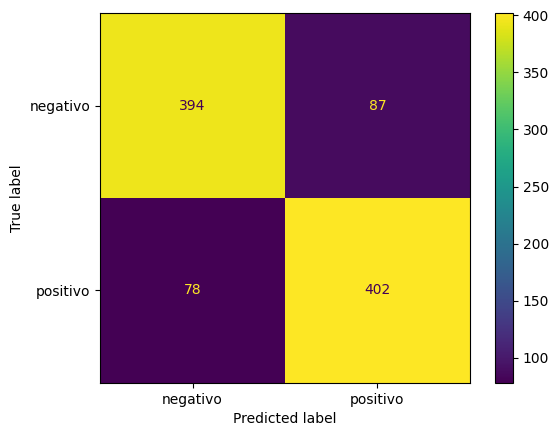

In [14]:
labels1= list(data['sentimiento'].unique())
labels1.reverse()
labels=[0,1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels1)
disp.plot()

## Exportando el pipeline

In [20]:
filename = 'pipe.joblib'
joblib.dump(pipe, '/content/pipe.joblib')

['/content/pipe.joblib']

In [16]:
enco='UTF-8'
data = pd.read_csv("/content/MovieReviewsPruebas.csv", encoding = enco,sep=',', header=0, index_col=0) 
df = data.copy()
pipeline_loaded = joblib.load(filename)
data['sentimiento'] = pipeline_loaded.predict(df)
data.sentimiento=data.sentimiento.map({
      1:'positivo',
      0:'negativo'
  })

In [17]:
data.head()

review_es sentimiento
0  La saga medieval alemana de Fritz Lang continú...    positivo
1  Este anime es una visita obligada para los fan...    positivo
2  Esta es una de las mejores películas para masc...    positivo
3  Cuando se lanzó su DVD, llegué al mercado y lo...    positivo
4  No me he reído tan duro en una película en muc...    positivo

In [18]:
data[(data['sentimiento']=='negativo')]

review_es sentimiento
10   Antes de perder todo lo que se muestra en la t...    negativo
15   Una comedia interesante, que tiene lugar en un...    negativo
19   Berlin-born in 1942 Margarethe von Trotta was ...    negativo
24   El enfoque apresurado que Lewis Seiler toma co...    negativo
27   Con rápidos interconectores de escenas de pers...    negativo
..                                                 ...         ...
293  Realmente desearía haber leído la revisión de ...    negativo
294  Bueno, recibí y vi esta película basada en el ...    negativo
295  1er vimos 2/18/2007 - 4 de 10 (Dir-Leon Leonar...    negativo
296  Desde su título no inspirado a las actuaciones...    negativo
298  Solía ​​trabajar en la compañía que originalme...    negativo

[149 rows x 2 columns]

In [19]:
data[(data['sentimiento']=='positivo')]

review_es sentimiento
0    La saga medieval alemana de Fritz Lang continú...    positivo
1    Este anime es una visita obligada para los fan...    positivo
2    Esta es una de las mejores películas para masc...    positivo
3    Cuando se lanzó su DVD, llegué al mercado y lo...    positivo
4    No me he reído tan duro en una película en muc...    positivo
..                                                 ...         ...
283  Soy un fanático de Jean Harlow, porque tenía u...    positivo
287  No se donde empezar.Quizás toda la idea de est...    positivo
288  El 'SNAFUPERMAN' de Friz Freleng es uno de los...    positivo
297  Encontré a esta buena película para pasar su t...    positivo
299  La dama en cemento es un verdadero curso sobre...    positivo

[151 rows x 2 columns]